# v3_from_t3p2_jpca.ipynb

This is a copy of v3_from_t3p2_ph2.ipynb specialized to produce the jPCA analysis.

In [1]:
%cd /home/z/projects/draculab/

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

In [3]:
# load a configuration
import pickle
#fname = '/home/z/projects/draculab/v3ft3p2ph1_pop_2021-05-25__10_19'
#fname = '/home/z/projects/draculab/v3ft3p2ph2_pop_2021-05-28__10_53'
fname = '/home/z/Dropbox (OIST)/saves/gene_2021-06-17'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()

In [4]:
# Best from june 18th
cfg = {  'A__M_w_max_frac': 0.2821474299061792,
         'A__M_w_sum': 1.0,
         'C_adapt_amp': 4.4,
         'C_cid': 0.14928385685463597,
         'C_sigma': 0.6235117516563925,
         'M_cid': 1.069072715299579,
         'M_des_out_w_abs_sum': 3.107279886064089,
         'g_e_factor': 3.0,
         'C_slope': 1.9679091114851834,
         'C_thresh': 1.1,
         'C_tau': 0.24470832173052345,
         'C_tau_slow': 16.25454530465845,
         'A__M_lrate': 8.0,
         'AL_thresh': 0.55,
         'b_e': 1.0,
         'C__C_antag': 1.5,
         'C__C_p_antag': 0.25,
         'C__C_p_syne': 0.3,
         'C__C_syne': 1.0,
         'CE__CI_w': 0.5,
         'CI__CE_w': -1.3,
         'M__C_lrate': 300.0,
         'M__C_w_sum': 2.3,
         'M__M_w': -0.5,
         'SPF__SPF_w': -1.5,
         'fitness': 0.0479887341710312,
         'n_evals': 2,
         't_pres': 40,
         'par_heter': 0.01,
         'g_e_03': 20.0,
         'CI_slope': 3.5,
         'CI_tau': 0.02572798162731093,
         'CI_thresh': 1.4,
         'II_g_03': 3.0,
         'M_tau': 0.01,
         'SF_thresh_03': 0.4}

In [5]:
np.random.seed(123456) # always the same random values

cfg = pop[0]
    
t_pres = cfg['t_pres']
par_heter = cfg['par_heter']
M_size = 12 # number of units in the M population
SPF_size = 12 # number of units in the SPF population
set_C_delay = False # whether set C_cid using analytical approach
rand_targets = True # whether to train using a large number of random targets
C_noise = True # whether C units are noisy (use euler_maru integrator)
M__C_rand_w = True # whether to randomly intialize weights for the M__C connections

In [6]:
cfg

{'A__M_w_max_frac': 0.225,
 'A__M_w_sum': 2.0,
 'C_adapt_amp': 4.4,
 'C_cid': 0.14928385685463597,
 'C_sigma': 0.6235117516563925,
 'M_cid': 1.069072715299579,
 'M_des_out_w_abs_sum': 3.107279886064089,
 'g_e_factor': 3.0,
 'C_slope': 2.2675408763677987,
 'C_thresh': 0.8919820536944196,
 'C_tau': 0.26003435786600343,
 'C_tau_slow': 21.0,
 'A__M_lrate': 8.0,
 'AL_thresh': 0.55,
 'b_e': 1.0,
 'C__C_antag': 1.5,
 'C__C_p_antag': 0.25,
 'C__C_p_syne': 0.3,
 'C__C_syne': 1.0,
 'CE__CI_w': 0.5,
 'CI__CE_w': -1.3,
 'M__C_lrate': 300.0,
 'M__C_w_sum': 2.3,
 'M__M_w': -0.5,
 'SPF__SPF_w': -1.5,
 'fitness': 0.041630394730014376,
 'n_evals': 1,
 't_pres': 40,
 'par_heter': 0.01,
 'g_e_03': 20.0,
 'CI_slope': 4.158365408276022,
 'CI_tau': 0.09203223283805521,
 'CI_thresh': 1.4,
 'II_g_03': 6.4857818119346735,
 'M_tau': 0.01,
 'SF_thresh_03': 0.4}

In [7]:
# Create the network with the net_from_cfg function
%cd /home/z/projects/draculab/notebook/spinal/
from v3ft3p2ph2_net import *
%cd ../..

net, pops_dict, hand_coords, m_idxs = net_from_cfg(cfg,
                                                   t_pres = t_pres,
                                                   par_heter = par_heter,
                                                   set_C_delay = set_C_delay,
                                                   rand_targets = rand_targets,
                                                   track_weights = True,
                                                   track_ips = True,
                                                   C_noise = C_noise,
                                                   M__C_rand_w = M__C_rand_w)

# net, pops_dict, hand_coords, m_idxs = syne_net(cfg,
#                                                t_pres = t_pres,
#                                                par_heter = par_heter,
#                                                set_C_delay = set_C_delay,
#                                                rand_targets = rand_targets,
#                                                track_weights = True,
#                                                track_ips = True,
#                                                C_noise = C_noise,
#                                                M__C_rand_w = M__C_rand_w)

for name in pops_dict:
    exec("%s = %s"% (name, str(pops_dict[name])))

/home/z/projects/draculab/notebook/spinal
/home/z/projects/draculab


In [8]:
# Some hacks to run jPCA analysis with networks from net_from_cfg
# The risk is that at some point these may no longer correspond to
# what's used in net_from_cfg
P__A_syn = {'type' : synapse_types.static,
            'init_w' : None }
P__A_syn['init_w'] = [syn_list[0].w for syn_list in [net.syns[a] for a in A]]
P__A_ws = np.array(P__A_syn['init_w'][12:18])
A__SF_syn = {'type' : synapse_types.static,
             'init_w' : [1.]*6 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : np.array([cfg['SF_thresh_03'], 0.4, 0.4, cfg['SF_thresh_03'], 0.4, 0.4]),
             'slope' : np.array([4.]*6),
             'init_val' : 0.2,
             'tau' : 0.02 }

In [ ]:
## Create the network directly

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Parameter dictionaries for the network and the plant
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
# plant parameters
P_params = {'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.8,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 3.,
          'mu2': 3.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : cfg['g_e_factor']*np.array([cfg['g_e_03'], 20., 20.,
                                              cfg['g_e_03'], 22., 23.]),
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10.,3.,10.,10.]),
          'II_gain' : 2.*np.array([cfg['II_g_03'], 8., 8.,
                                   cfg['II_g_03'], 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 20.,  #8
          'k_se_e' : 20., #13
          'b_e' : cfg['b_e'],
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
#--------------------------------------------------------------------
# Unit parameters
#--------------------------------------------------------------------
randz = lambda n: (1. + par_heter*(np.random.rand(n)-0.5))

A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : np.array([.2]*6 + [0.]*6 + [.2]*6) } # [Ib, Ia, II]
ACT_params = {'type' : unit_types.act,
              'tau_u' : 10., #6., #8
              'gamma' : 8., #6., #2
              'g' : 2.,
              'theta' : 1.5, #1.,
              'tau_slow' : 5.,
              'y_min' : 0.1, #0.2
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = 1. # .6 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : cfg['AL_thresh'] * randz(6),
             'slope' : 2. * randz(6),
             'init_val' : 0.1 * randz(6),
             'tau' : 0.02 * randz(6) }
CE_params = {'type' : unit_types.rga_adapt_sig,
            'integ_meth' : 'euler_maru' if C_noise else 'odeint',
            'init_val' : [r*np.array([0.5]) for r in np.random.random(6)],
            'multidim' : False,
            'slope' : cfg['C_slope'],
            'thresh' : cfg['C_thresh'],
            'tau' : cfg['C_tau'],
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : cfg['C_tau_slow'],
            'custom_inp_del' : int(round(cfg['C_cid']/net_params['min_delay'])),
            'delay' : 0.31, # to be set below
            'adapt_amp' : cfg['C_adapt_amp'],
            'mu' : 0.,
            'sigma' : cfg['C_sigma'] }
CI_params = {'type' : unit_types.rga_adapt_sig,
            'integ_meth' : 'euler_maru' if C_noise else 'odeint',
            'init_val' : [r*np.array([0.5]) for r in np.random.random(6)],
            'multidim' : False,
            'slope' : cfg['CI_slope'] if 'CI_slope' in cfg else cfg['C_slope'],
            'thresh' : cfg['CI_thresh'] if 'CI_thresh' in cfg else cfg['C_thresh'], 
            'tau' : cfg['CI_tau'] if 'CI_tau' in cfg else cfg['C_tau'],
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : cfg['C_tau_slow'],
            'custom_inp_del' : int(round(cfg['C_cid']/net_params['min_delay'])),
            'delay' : 0.31, # to be set below
            'adapt_amp' : cfg['C_adapt_amp'],
            'mu' : 0.,
            'sigma' : cfg['C_sigma'] }
M_params = {'type' : unit_types.m_sig,
            'thresh' : 0.5 * randz(M_size) + cfg['A__M_w_sum'] / 2.,
            'slope' : 2.5 * randz(M_size),
            'init_val' : 0.2 * randz(M_size),
            'delay' : 0.35, # to be set below
            'n_ports' : 4,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 8.,
            'tau' : cfg['M_tau'] * randz(M_size),
            'integ_amp' : 0.,
            'custom_inp_del' : int(np.round(cfg['M_cid']/net_params['min_delay'])) ,
            'des_out_w_abs_sum' : cfg['M_des_out_w_abs_sum'] }
# SF, SP
SFth = cfg['SF_thresh_03']
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : np.array([SFth, 0.4, 0.4, SFth, 0.4, 0.4]),
             'slope' : np.array([4.]*6),
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.01,
             'tau_mid' : 0.2,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.25,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
# 1-D error units
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.1 * randz(SPF_size),
              'slope' : 9. * randz(SPF_size),
              'init_val' : 0.3 * randz(SPF_size),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz(SPF_size) }      
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]

# Afferent to motor error selection
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, 
            'inp_ports' : 2, # the default for m_sig targets
            'error_port' : 1, # the default for m_sig targets
            'aff_port' : 2,
            'lrate' : cfg['A__M_lrate'], # negative rate for m_sig targets with value inputs
            'w_sum' : cfg['A__M_w_sum'],
            'w_max' : cfg['A__M_w_max_frac']*cfg['A__M_w_sum'],
            'init_w' : .1 }
A__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
A__SF_syn = {'type' : synapse_types.static,
             'init_w' : [1.]*6 }
# ACT to C ------------------------------------------------
ACT__C_conn = {'rule' : "all_to_all",
               'delay' : 0.02 } 
ACT__C_syn = {'type' : synapse_types.static,
              'inp_ports' : 2,
              'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : 1. }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI within the same population -----------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : cfg['CE__CI_w'] }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 1,
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : cfg['CI__CE_w'] }
# synergist and antagonist connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
C__C_syn_antag = {'type' : synapse_types.static,
                  'inp_ports': 1, # "lateral" port of rga_21 synapses
                  'init_w' : cfg['C__C_antag'] }
C__C_syn_p_antag = {'type' : synapse_types.static,
                    'inp_ports': 1,
                    'init_w' : cfg['C__C_p_antag'] }
C__C_syn_syne = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : cfg['C__C_syne'] }
C__C_syn_p_syne = {'type' : synapse_types.static,
                  'inp_ports': 1,
                  'init_w' : cfg['C__C_p_syne']}
C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 1,
                   'init_w' : 0. }
# spinal units to plant
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.02 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# motor to spinal
if not M__C_rand_w:
    # initializing M__C weights manually
    M_CE = np.array(
        [[ 1., .3, 0.,-.5, .3, 0.],
         [ .3, 1.,-.5, 0., 0., 0.],
         [ 0.,-.5, 1., .3, 0., 0.],
         [-.5, 0., .3, 1., 0., .3],
         [ .3, 0., 0., 0., 1.,-.5],
         [ 0., 0., 0., .3,-.5, 1.]])
    M_CE = M_CE.flatten('C')
    M_CE = np.concatenate((M_CE, -M_CE))
    M_CI = -M_CE
    M__CE_iw = M_CE
    M__CI_iw = M_CI
else:
    M__CE_iw = {'distribution':'uniform', 'low':0.05, 'high':.1}
    M__CI_iw = {'distribution':'uniform', 'low':0.05, 'high':.1}
    
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.rga_21,
             'lrate': cfg['M__C_lrate'],
             'inp_ports': 0,
             'w_sum' : cfg['M__C_w_sum'],
             'init_w' : M__CE_iw}
M__CI_syn = {'type' : synapse_types.rga_21,
             'lrate': cfg['M__C_lrate'],
             'inp_ports': 0,
             'w_sum' : cfg['M__C_w_sum'],
             'init_w' : M__CI_iw}
# motor error lateral connections
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.02 } # the delay assumes an intermediate interneuron
M__M_syn = {'type' : synapse_types.static,
            'inp_ports': 3, # default for m_sig targets
            'init_w' : cfg['M__M_w'] }
# plant to afferent
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__A_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [2.]*6 + [2.]*6 + [4.]*6 } # weights for [Ib, Ia, II]
# SF/SP to SPF
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG ------------------------------------------------
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to ACT ------------------------------------------------
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SPF to ACT ------------------------------------------------
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.02 }
SPF__M_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'init_w' : 1. }
# sensory error lateral connections
SPF__SPF_conn = {'rule': 'one_to_one',
                 'allow_autapses' : False,
                 'delay' : 0.02 } # the delay assumes an intermediate interneuron
SPF__SPF_syn = {'type' : synapse_types.static,
                'inp_ports': 0,
                'init_w' : cfg['SPF__SPF_w'] }
# utility function to set C_params['custom_inp_del']
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.

        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-A-M-C.

        Args:
            f : main oscillation frequency of in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    a_del = np.arctan(np.mean(A_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__A_conn['delays']),
         A__M_conn['delay'], M__C_conn['delay'] ]
    time_del = al_del + p_del + a_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps

if set_C_delay is True:
    C_time_del, C_del_steps = approx_del(1.)
    CE_params['custom_inp_del'] = C_del_steps
    CI_params['custom_inp_del'] = C_del_steps

CE_params['delay'] = (CE_params['custom_inp_del'] + 2) * net_params['min_delay']
CI_params['delay'] = (CI_params['custom_inp_del'] + 2) * net_params['min_delay']
M_params['delay'] = max(CE_params['delay'], CI_params['delay'],
                    (M_params['custom_inp_del'] + 2) * net_params['min_delay'])

#--------------------------------------------------------------------
# CREATING NETWORK AND UNITS
#--------------------------------------------------------------------
net = network(net_params)

A = net.create(18, A_params)
AL = net.create(6, AL_params)
ACT = net.create(1, ACT_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
P = net.create(1, P_params)
SF = net.create(6, SF_params)
SP = net.create(6, SP_params)
SP_CHG = net.create(1, SP_CHG_params)
SPF = net.create(12, SPF_params)

# tracking units
M_CE0_track = net.create(M_size, track_params) # to track weights from M to C0
A_M0_track = net.create(12, track_params) # to track weights from A to M0
ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--
# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
if rand_targets is False:
    hand_coords = [[0.3, 0.45], 
                   [0.35, 0.4],
                   [0.4, 0.35],
                   [0.35, 0.3],
                   [0.3, 0.25],
                   [0.25, 0.3],
                   [0.2, 0.35],
                   [0.25, 0.4]]
else:
    # creating a list of random coordinates to use as targets
    min_s_ang = -0.1 # minimum shoulder angle
    max_s_ang = 0.8  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    n_coords = 1000 # number of coordinates to generate
    l_arm = net.plants[P].l_arm # upper arm length
    l_farm = net.plants[P].l_farm # forearm length
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(s_angs[i]) + l_farm*np.cos(s_angs[i]+e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(s_angs[i]) + l_farm*np.sin(s_angs[i]+e_angs[i]) # y-coordinate

# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(net.plants[P].coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
#Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
#Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
#Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
P__A_ws = np.array(P__A_syn['init_w'][12:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
A_thr = np.array([net.units[u].thresh for u in A[12:18]])
A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from A to SF
SF_arg = A__SF_syn['init_w']*A_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    #m_idxs[0] = 0 # for testing
A_us = [net.units[u] for u in A]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor(t/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        A__SF_syn['init_w'][idx] * (
                        np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                        net.units[A[12+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))
#--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--

#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
# From afferent units
net.connect(A[:12], M, A__M_conn, A__M_syn)
net.connect(A[12:18], SF, A__SF_conn, A__SF_syn)
# From ACT
net.connect(ACT, CE, ACT__C_conn, ACT__C_syn)
net.connect(ACT, CI
            , ACT__C_conn, ACT__C_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# intraspinal connections
for pair in all_pairs:
    if pair in synergists:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
        #net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_syne:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
        #net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in antagonists:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
        #net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_antag:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
        #net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        #net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in self_conn:
        net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
        net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
#     else:
#         net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
#         net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
#         net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
#         net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
# From M 
net.connect(M, CE, M__C_conn, M__CE_syn)
net.connect(M, CI, M__C_conn, M__CI_syn)
net.connect(M, M, M__M_conn, M__M_syn)
# From plant to afferents
net.set_plant_outputs(P, A, P__A_conn, P__A_syn) 
# From SF, SP to SPF
net.connect(SF, SPF[:6], SFe__SPF_conn, SFe__SPF_syn)
net.connect(SF, SPF[6:12], SFi__SPF_conn, SFi__SPF_syn)
net.connect(SP, SPF[:6], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SP, SPF[6:12], SPe__SPF_conn, SPe__SPF_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# From SPF
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
net.connect(SPF, SPF, SPF__SPF_conn, SPF__SPF_syn)

# SETTING UP WEIGHT TRACKING
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
base = 0
for idx in range(len(M)):
    rga_syn = False
    while not rga_syn:
        if net.syns[CE[0]][base+idx].type in [synapse_types.rga_21]:
            rga_syn = True
        else:
            base += 1
            if base > 100:
                raise AssertionError('Could not create M_CE tracker unit')
    net.units[M_CE0_track[idx]].set_function(M_CE0_fun(base+idx))

def A_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
base = 0
for idx, uid in enumerate(A_M0_track):
    rga_syn = False
    while not rga_syn:
        if net.syns[M[0]][base+idx].type in [synapse_types.inp_sel]:
            rga_syn = True
        else:
            base += 1
            if base > 100:
                raise AssertionError('Could not create A_M tracker unit')
    net.units[uid].set_function(A_M0_fun(base+idx))


# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [9]:
# Run simulation1
sim_time = 200.
start_wctime = time.time()
times, data, plant_data  = net.flat_run(sim_time)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_wctime))

Execution time is 409.3213720321655 seconds


In [10]:
# set new targets

arm = net.plants[P]
t_pres = 10. # new presentation time
n_trgs = 8 # number of targets
n_rounds = 2 # number of times the n_trgs targets will be presented
start_t = net.sim_time # starting time for new simulation
# 8 radial targets in sequence, from 0 to 315 degrees
r = 0.12 # distance from center to targets
center = np.array([0.3, 0.3]) # initial hand location
angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
targets = center + r*circle # coordinates of the targets

# version with permuted targets
trg_ids = np.random.permutation(n_trgs*n_rounds)%8 # target for each presentation
hand_coords = []
for idx in trg_ids:
    hand_coords += [center, targets[idx]]
    
# version with sequential targets
# hand_coords = [center, targets[0],
#                center, targets[1],
#                center, targets[2],
#                center, targets[3],
#                center, targets[4],
#                center, targets[5],
#                center, targets[6],
#                center, targets[7]]

# hand_coords = n_rounds * hand_coords # many repetitions of the same sequence

# A simple variation
#hand_coords = 10*[targets[i] for i in np.random.permutation(len(targets))]

#### next is a copy-pasta of the code to set the SP values
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
#Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
#Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
#Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the afferent units
P__A_ws = np.array(P__A_syn['init_w'][12:18])
#Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
A_thr = np.array([net.units[u].thresh for u in A[12:18]])
A_II = np.log(1. + np.maximum((II_ss)*P__A_ws - A_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from A to SF
SF_arg = A__SF_syn['init_w']*A_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
#m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
m_idxs = list(range(len(hand_coords))) # reach list targets sequentially
    #m_idxs[0] = 0 # for testing
A_us = [net.units[u] for u in A]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor((t-start_t)/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        A__SF_syn['init_w'][idx] * (
                        np.log(1. + max(II_ss[cur_target(t)][idx] * P__A_ws[idx] - 
                        net.units[A[12+idx]].thresh, 0.))))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

In [11]:
# Run simulation for radial reaches
sim_time2 = t_pres * len(hand_coords)
start_wctime = time.time()
times, data, plant_data  = net.flat_run(sim_time2)

data = np.array(data)
print('Execution time is %s seconds' % (time.time() - start_wctime))

Execution time is 638.825679063797 seconds


[0.32078378 0.05513622 0.62250674 0.25230044 0.80747767 0.00841493
 0.26059786 0.73699943 0.09117179 0.32995197 0.03802286 0.95288863]
[0.22590244 0.14154539 0.41141871 0.20066058 0.49077188 0.12310714
 0.20556813 0.48292354 0.1404018  0.22012134 0.12904366 0.58293867]


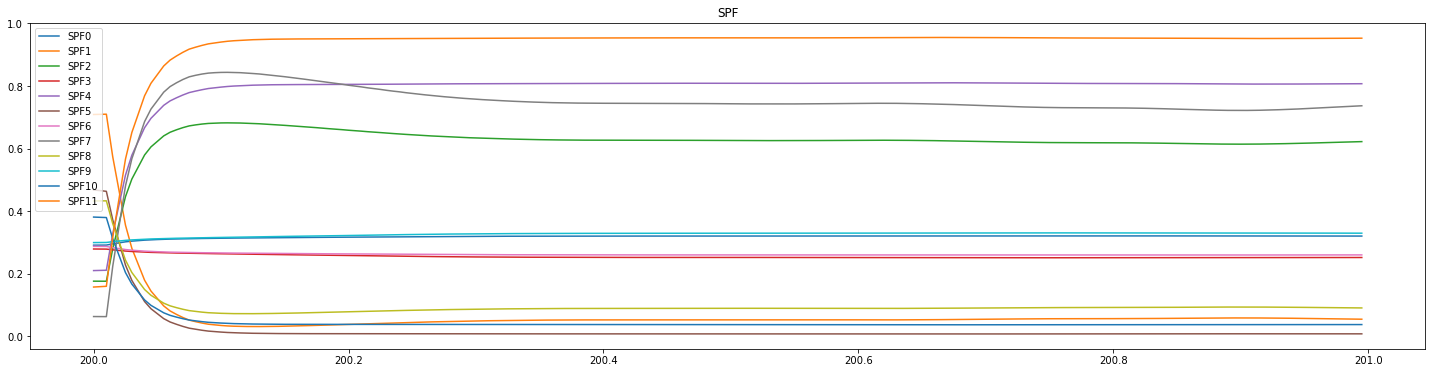

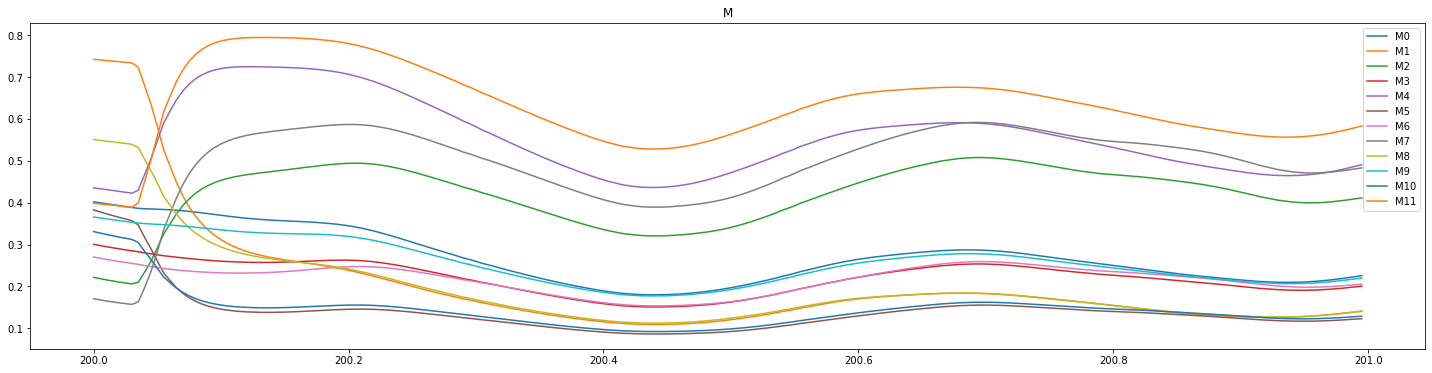

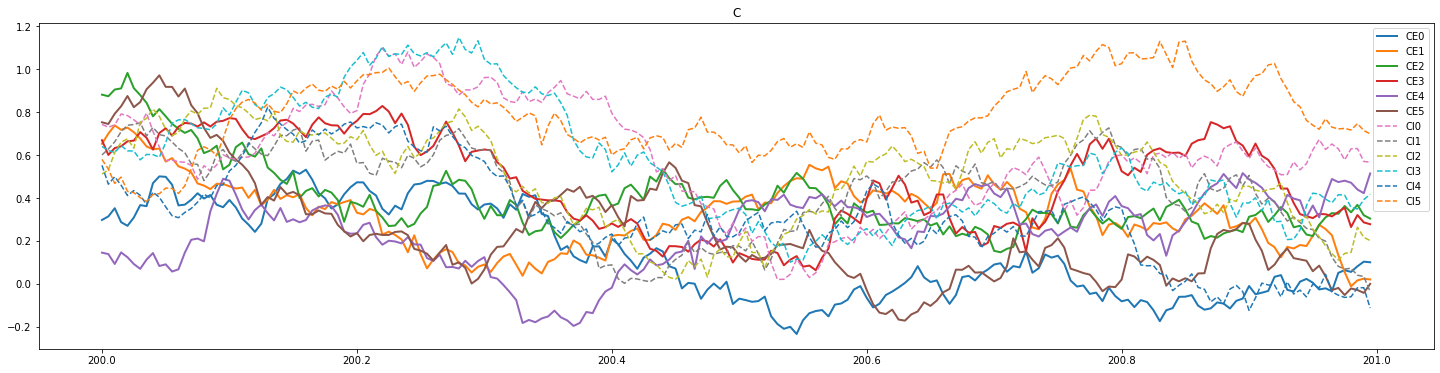

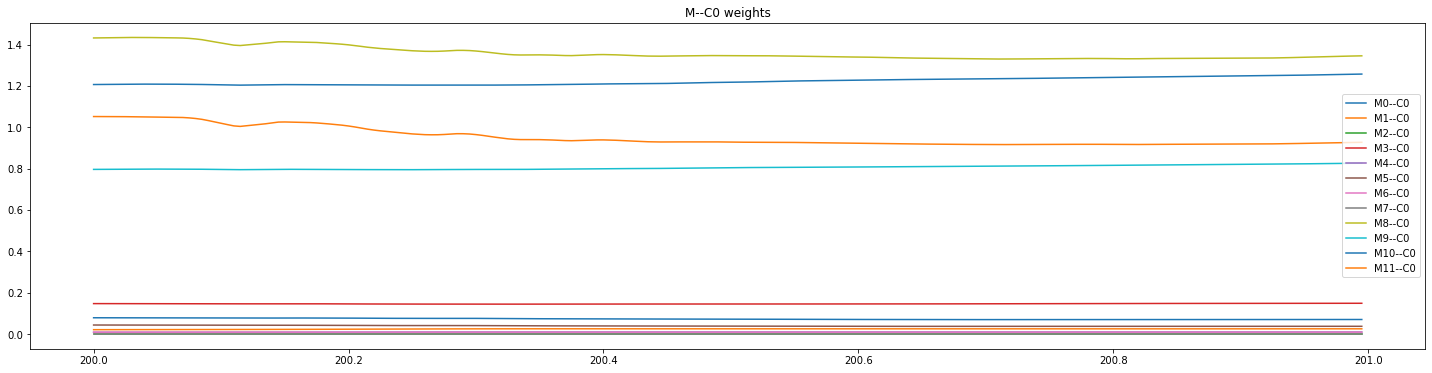

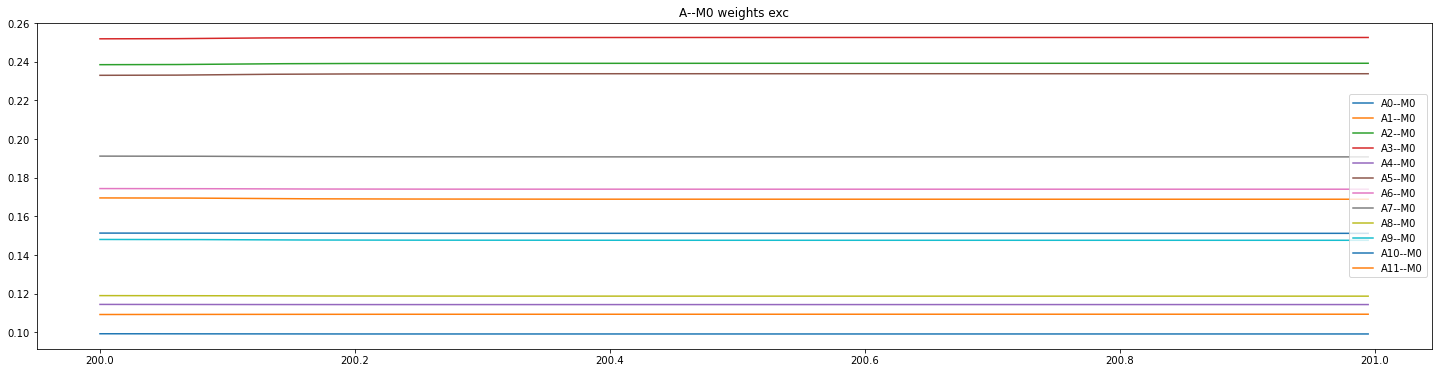

In [98]:
arm_activs = plant_data[P]

n_plot = 200 # number of time points to plot
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF,:n_plot])
plt.plot(times[:n_plot], SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M,:n_plot])
plt.plot(times[:n_plot], M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE,:n_plot])
CI_data = np.array(data[CI,:n_plot])
plt.plot(times[:n_plot], CE_data.transpose(), linewidth=2)
plt.plot(times[:n_plot], CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE0_track,:n_plot])
plt.plot(times[:n_plot], w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--C0' for i in range(len(M_CE0_track))]
plt.legend(M_CE0_legends)
plt.title('M--C0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track[0:18],:n_plot])
plt.plot(times[:n_plot], w_track_data2.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track[:12]))]
plt.legend(A_M0_legends)
plt.title('A--M0 weights exc')
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[AF_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh')
"""

plt.show()

shoulder angle: 0.030832, shoulder vel: 1.101367
A_data:
[1.15498318e-001 6.39911197e-001 4.06311247e-001 4.89022548e-001
 1.41510592e-001 5.64883317e-001 2.40946873e-001 1.16424560e-001
 2.86499832e-001 1.34484345e-001 4.23471871e-001 4.64582620e-112
 1.24532315e+000 5.62957788e-001 5.65024048e-001 1.03927198e+000
 7.55189213e-001 2.87976353e-001]


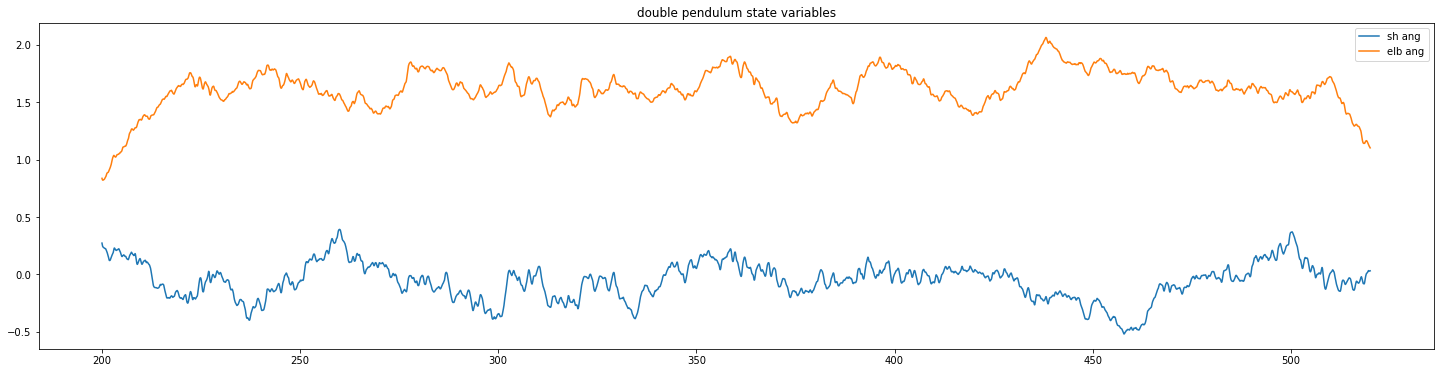

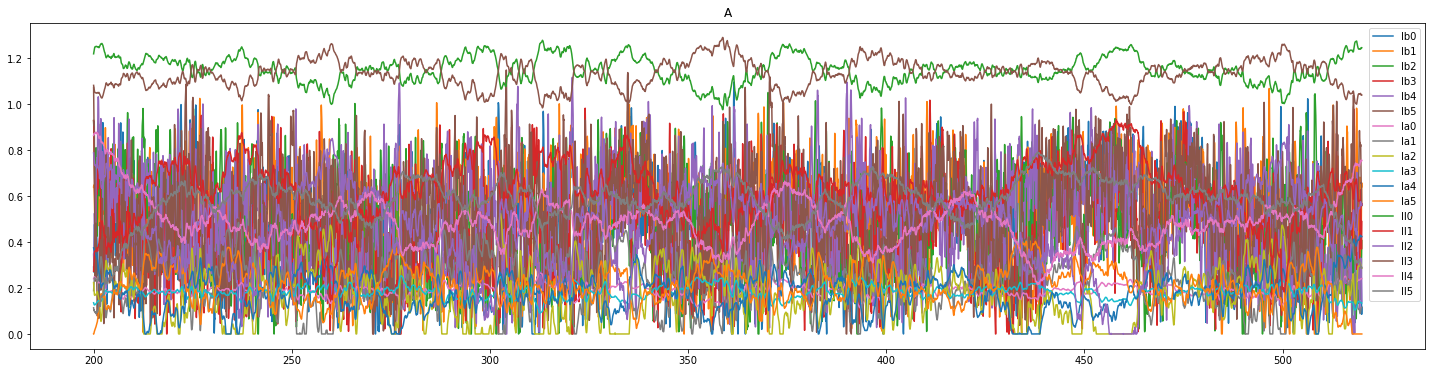

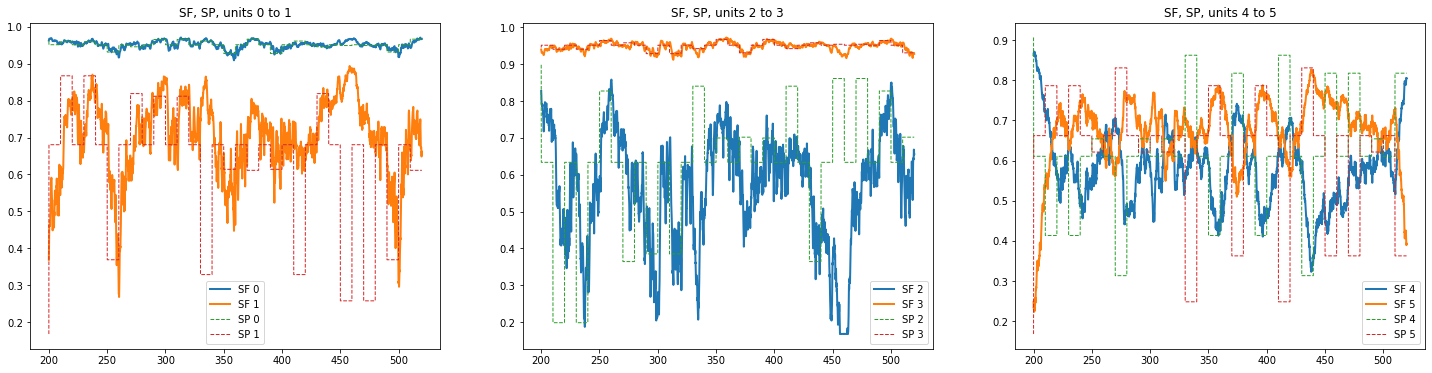

SF = 
[0.96718569 0.66121922 0.6552943  0.92781848 0.80436827 0.39219967]
SP = 
[0.96628983 0.6111733  0.7018348  0.93060237 0.81750526 0.36251198]


In [13]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A[0:18]])
plt.plot(times, A_data.transpose())
A_legends = ['Ib' + str(i) for i in range(6)] + \
            ['Ia' + str(i) for i in range(6)] + \
            ['II' + str(i) for i in range(6)]
plt.legend(A_legends)
plt.title('A')
print('A_data:')
print(A_data[:,-1])

#fs = (30,6)
# SF, SP
SF_fig, axs = plt.subplots(1, 3, figsize=(fs[0], fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
if 'lowpass_SP' in locals() and lowpass_SP is True:
    LPF_SP_data = np.array(data[LPF_SP])
for col in range(3):
    ax = axs[col]
    base = 2*col
    ax.plot(times, SF_data[base:base+2, :].transpose(), linewidth=2)
    ax.plot(times, SP_data[base:base+2, :].transpose(), '--', linewidth=1)
    if 'lowpass_SP' in locals() and lowpass_SP is True:
        ax.plot(times, LPF_SP_data[base:base+2, :].transpose(), linewidth=2)
    ax.set_title('SF, SP, units %d to %d' % (base, base+1))
    SF_legends = ['SF '+ str(base+i) for i in range(2)]
    SP_legends = ['SP '+ str(base+i) for i in range(2)]
    ax.legend(SF_legends + SP_legends)

plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

average error: 0.069264


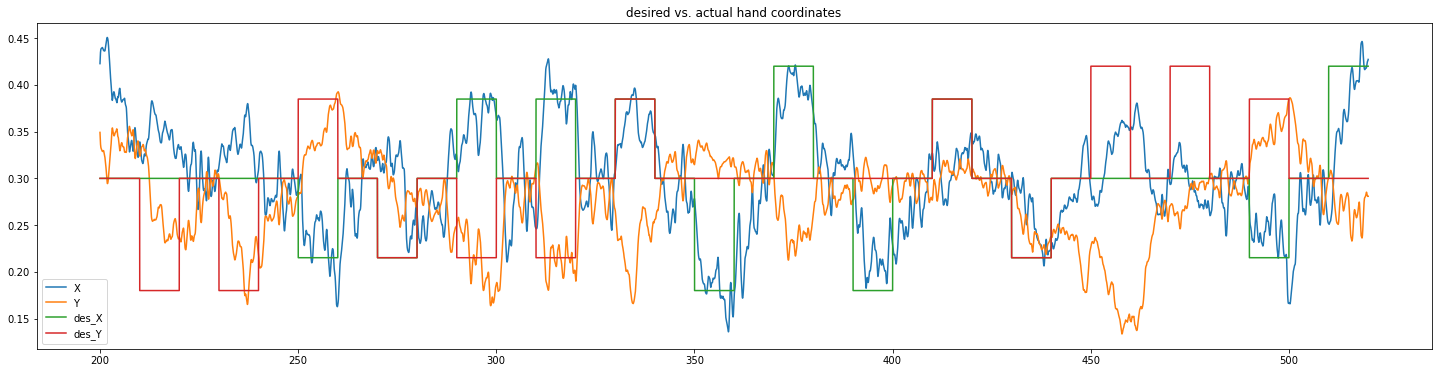

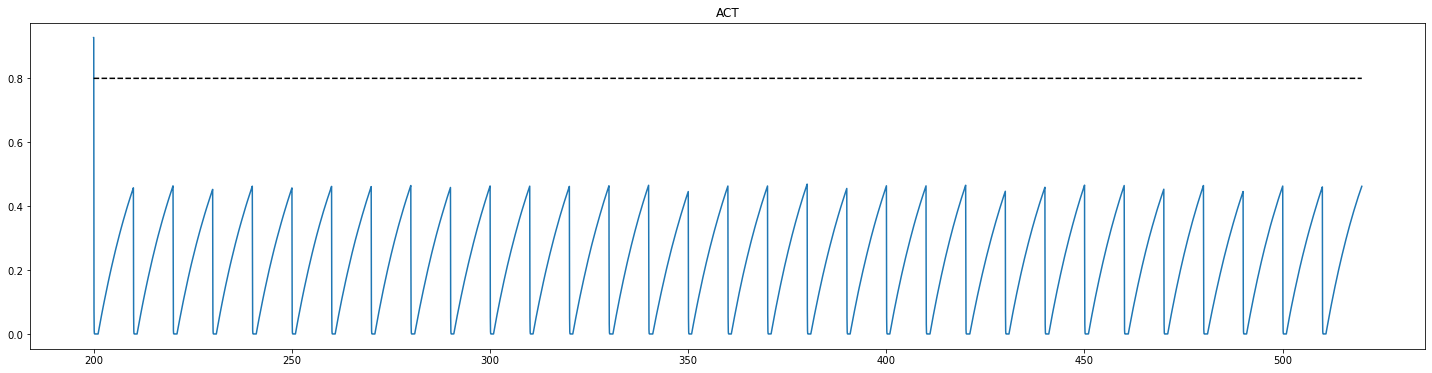

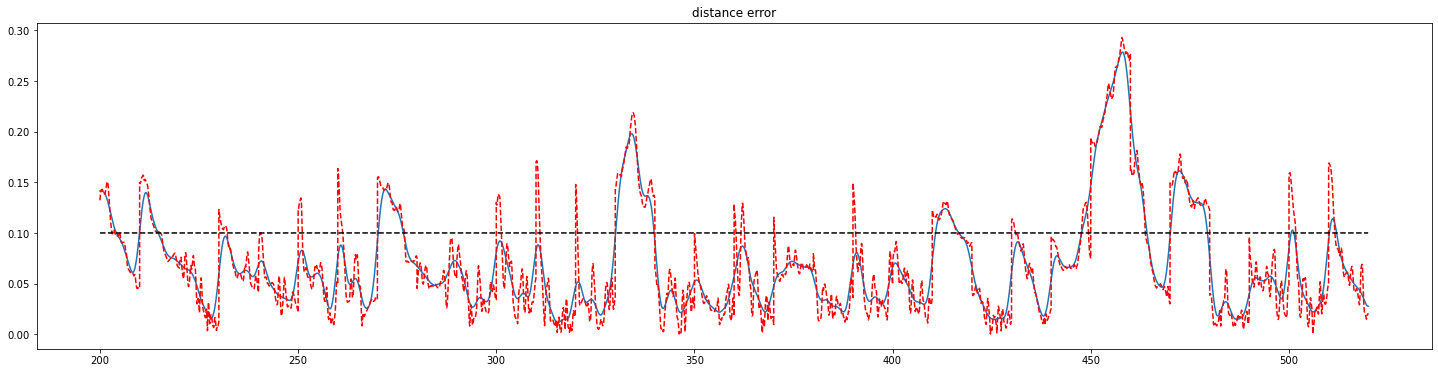

In [14]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
if 'start_t' in locals():
    coord_idxs = np.floor((times-start_t)/t_pres).astype(int) # after resetting the targets
    des_coords = np.array([hand_coords[idx] for idx in [m_idxs[cid] for cid in coord_idxs]])
else:
    coord_idxs = np.floor(times/t_pres).astype(int)  # before resetting the targets
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates')
plt.legend(['X', 'Y', 'des_X', 'des_Y'])

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('ACT')

err_fig = plt.figure(figsize=fs)
w_len = 1001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.plot(times, hand_error, 'r--')
plt.plot(times, 0.1+np.zeros(smooth_hand_error.size), 'k--')
plt.title('distance error')
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))

plt.show()

AL_data:
[0.07221899 0.1829444  0.1961266  0.2364429  0.04539099 0.26608309]
Ib avg for muscle 0= 0.4102329676464064
Ia avg for muscle 0= 0.10261282237053507
II avg for muscle 0= 0.5908584651718609
Ib avg for muscle 1= 0.4263661676351815
Ia avg for muscle 1= 0.13215720917270204
II avg for muscle 1= 0.271307367991751
Ib avg for muscle 2= 0.4142452521144606
Ia avg for muscle 2= 0.09003738355292407
II avg for muscle 2= 0.20374999237849178
Ib avg for muscle 3= 0.38547466659844626
Ia avg for muscle 3= 0.09985128480917559
II avg for muscle 3= 0.577309837046051
Ib avg for muscle 4= 0.43368321557926537
Ia avg for muscle 4= 0.0937443199403967
II avg for muscle 4= 0.2078558489050166
Ib avg for muscle 5= 0.44839841351497634
Ia avg for muscle 5= 0.12101818854811201
II avg for muscle 5= 0.250909049439673


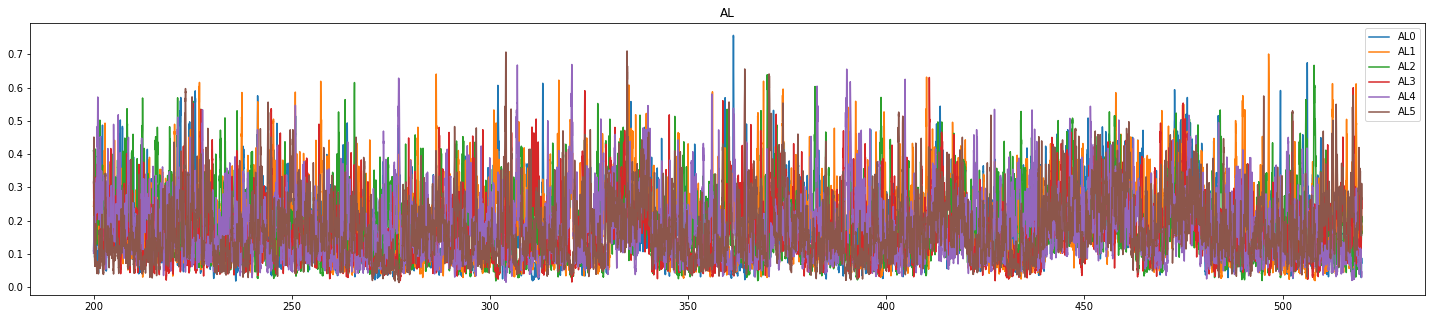

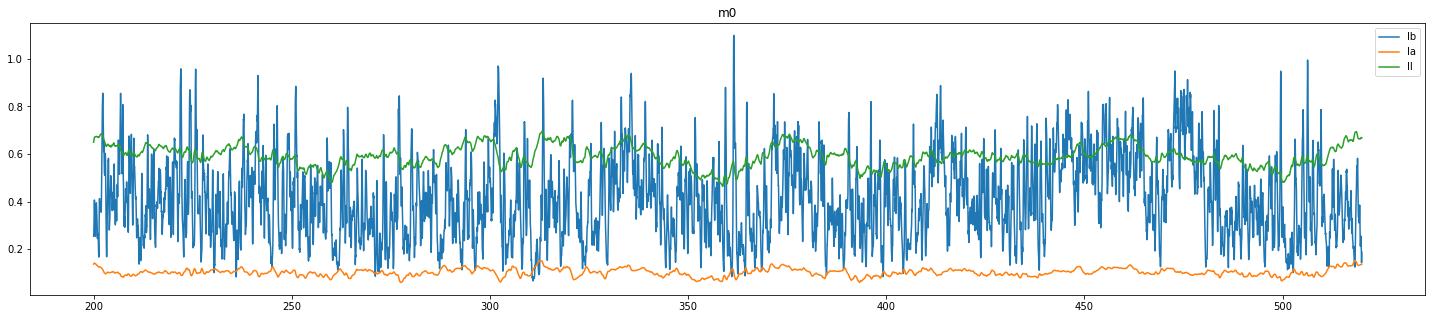

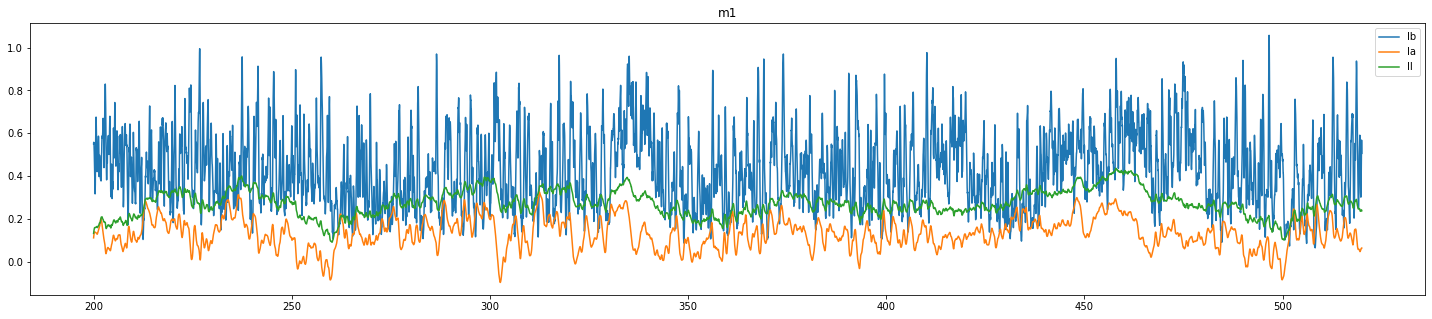

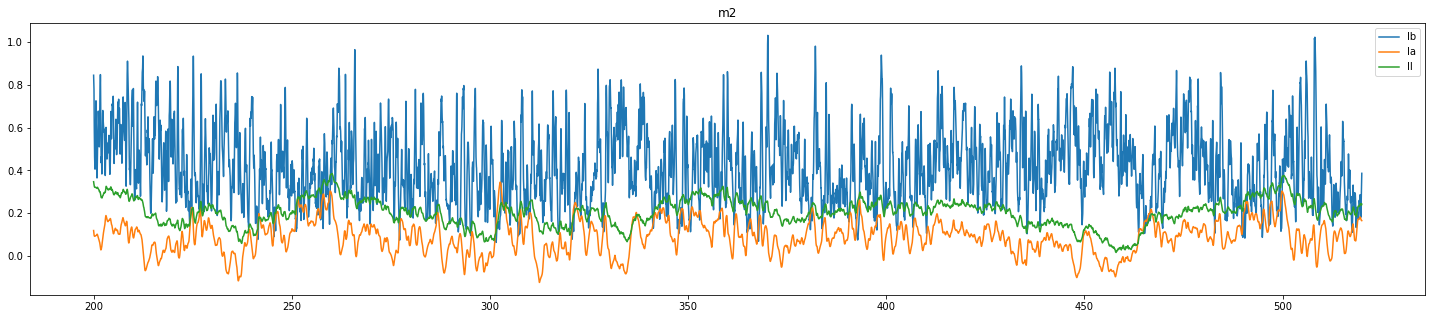

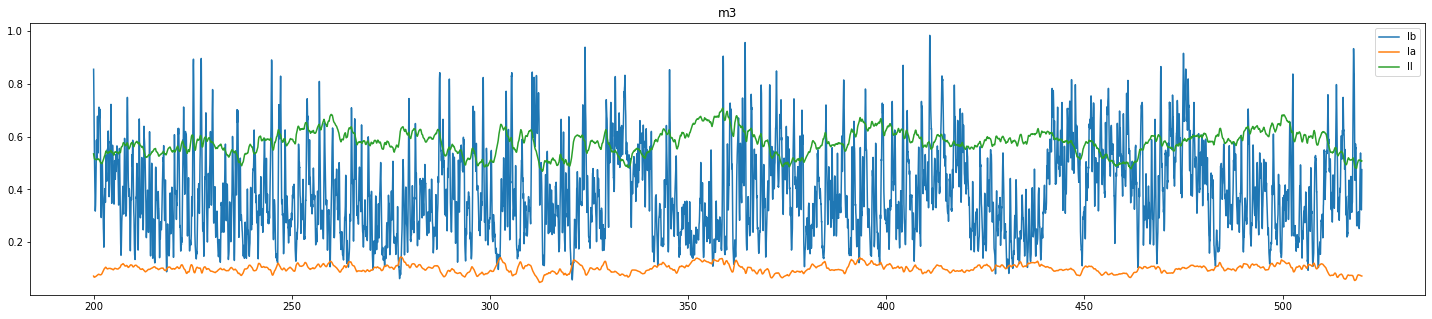

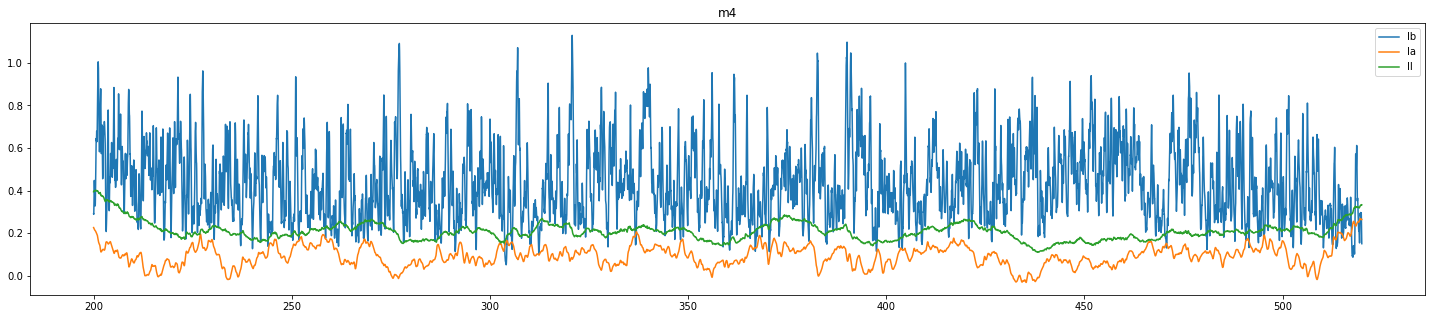

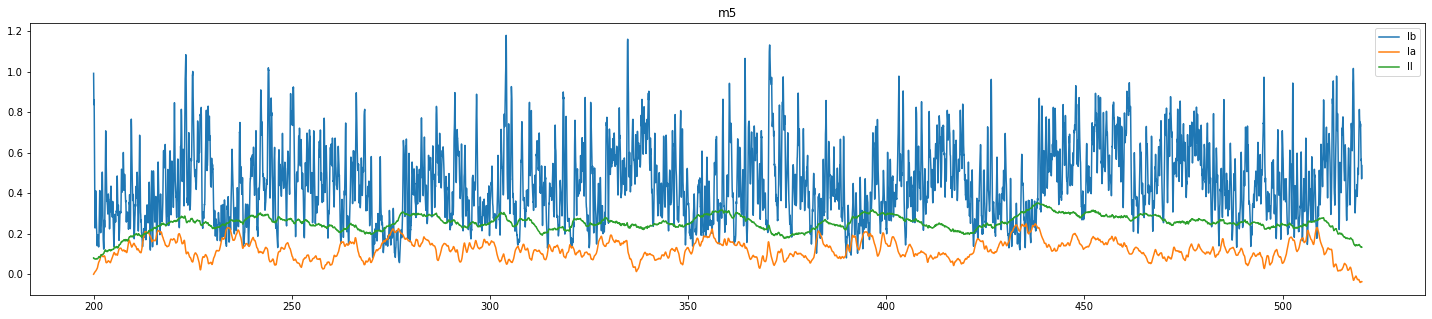

In [15]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs2 =(25,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

In [ ]:
# prepare data for animation
from numpy import cos, sin
if not 'targets' in locals():
    targets = np.array([[0.3, 0.3]])
start_time = 0.
start_idx = int(start_time/net.min_delay)
fdelay = 4000 # number of frames to plot for hand trajectory
# angles of shoulder and elbow
theta_s = arm_activs[start_idx:,0]
theta_e = arm_activs[start_idx:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
#acts = np.array(data[1])
ipx = data[ipx_track,start_idx:]
ipy = data[ipy_track,start_idx:]
ten = arm_activs[start_idx:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2


In [ ]:
#Animation of the arm and muscles
%matplotlib widget
from matplotlib.animation import FuncAnimation
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-.2, lim])
ax.set_ylim([-.2, lim])
ax.grid()
ax.scatter(targets[:,0], targets[:,1], s=150, c='cyan')
# creating lines and points
line, = ax.plot([], [], 'o-k', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
traj, = ax.plot([], [], 'tab:gray', lw=1)
pred_vel, = ax.plot([], [], 'r-o')
ax.scatter([0.3], [0.3], s=200, c='cyan')
# preparing a colormap for the tensions
ten_max = np.mean(np.max(ten, axis=1))
ten_min = np.mean(np.min(ten, axis=1))
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
#strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs
strt_idx = int(np.round((times[0]+start_time)/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    traj.set_data([], [])
    pred_vel.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    #traj.set_data(xh[0:frame], yh[0:frame])
    #traj.set_data(xh[frame-max(0,frame-fdelay):frame], yh[frame-max(0,frame-fdelay):frame])
    if frame > fdelay:
        traj.set_data(xh[frame-fdelay:frame], yh[frame-fdelay:frame])
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = (frame+start_idx)*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    #cur_idx = int(cur_time/t_pres) + strt_idx
    #cur_idx = int(frame*net.min_delay/t_pres) + strt_idx
    cur_idx = int(frame*net.min_delay/t_pres)  # if using new targets
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    # plotting predicted velocity
    #pred_vel.set_data([xh[frame], xh[frame]+0.3*pred_v[0][frame]], [yh[frame], yh[frame]+0.3*pred_v[1][frame]])
    #pred_vel.set_data([xh[frame], xh[frame]+5.*pred_v2[0][frame]], [yh[frame], yh[frame]+5.*pred_v2[1][frame]])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

#plt.show()

In [ ]:
# alternate way to display the animation
from IPython.display import HTML
#HTML(ani.to_jshtml(fps=20))
HTML(ani.to_html5_video())

In [ ]:
# save the animation
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Sergio Verduzco'), bitrate=2000)
ani.save('/home/z/Dropbox (OIST)/saves/new_pars_gen10.mp4', writer=writer)

In [206]:
# jPCA analysis part 1

# m_tensor[i,j,k,t] wis the activity of the i-th M 
# unit for target j, on the k-th repetition, at time t. 

# the first step is to obtain m_tensor
t_smp = .18 # time to sample M (in seconds)
t_strt = 0.07 # time after target onset when sample begins
idx_strt = int(t_strt / net.min_delay)

I = 6 # number of dimensions to consider in M
J = n_trgs # number of targets
K = n_rounds # number of repetitions per target
T = int(t_smp / net.min_delay) # number of time points

m_tensor = np.zeros((I,J,K,T), dtype=np.float_)

trg_reps = np.zeros(J, dtype=int) # how many repetitions of each target we have filled
pt_per_pres = int(round(t_pres / net.min_delay))
for reach, trg in enumerate(trg_ids):
    init_tid = (1 + 2 * reach) * pt_per_pres + idx_strt
    final_tid = init_tid + int(t_smp/net.min_delay) # t_smp seconds later
    m_tensor[:, trg, trg_reps[trg],:] = data[M[0]:M[I], init_tid:final_tid]
    trg_reps[trg] += 1
    
# Normalize responses in m_tensor
for i in range(I):
    for j in range(J):
        for k in range(K):
            norm = np.linalg.norm(m_tensor[i,j,k,:])
            m_tensor[i,j,k,:] = m_tensor[i,j,k,:] / norm
    
# Now we average across repetitions for the same target
p_tensor = m_tensor.sum(axis=2) / K

# We obtain the across-condition average
a_tensor = p_tensor.sum(axis=1) / J

# Obtained a normalized average trace per condition
c_tensor = np.zeros_like(p_tensor)
for trg in range(J):
    c_tensor[:, trg, :] = p_tensor[:, trg, :] - a_tensor

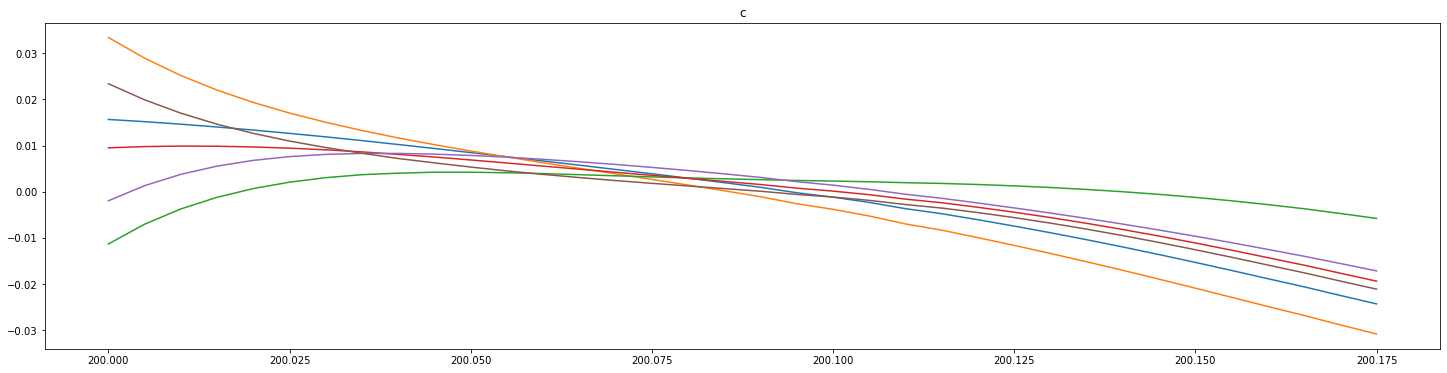

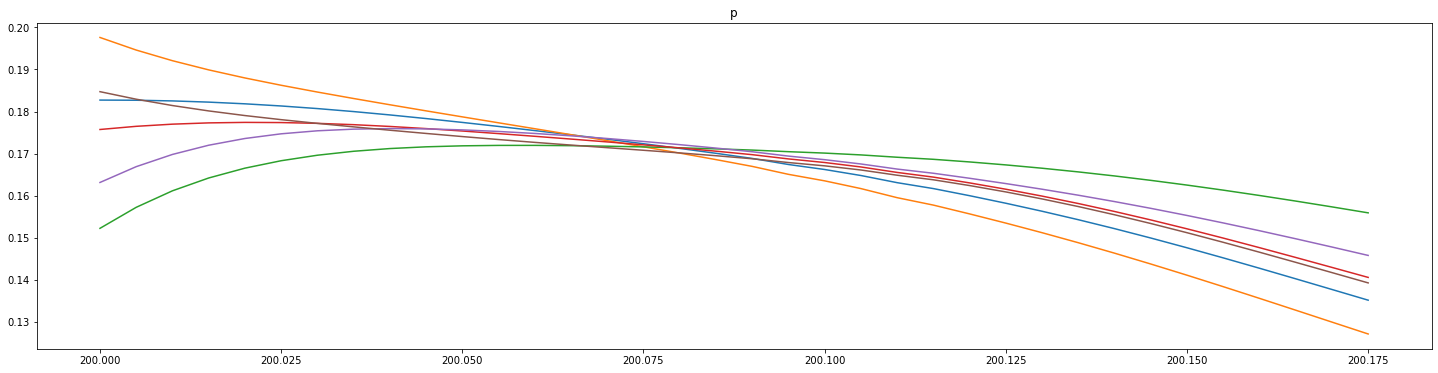

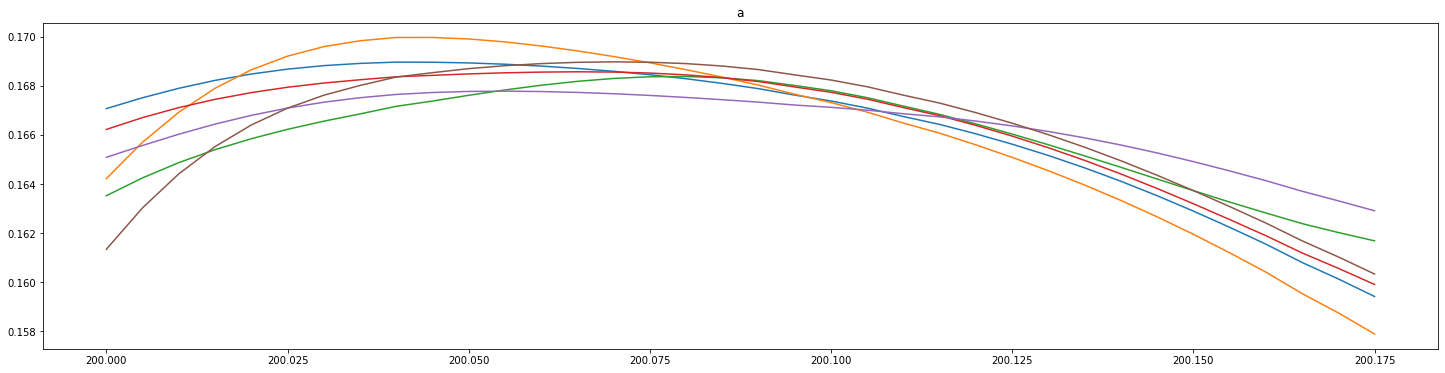

In [207]:
munit = 0
# trg_fig = plt.figure(figsize=fs)
# plt.plot(times[:T], m_tensor[munit,5,0,:])

# M_fig = plt.figure(figsize=fs)
# # M_data = np.array(data[M])
# # plt.plot(times[:T], M_data[munit,:T])
# plt.plot(times[pt_per_pres:pt_per_pres+T], data[M[0], pt_per_pres:pt_per_pres+T])

c_fig = plt.figure(figsize=fs)
plt.plot(times[:T], c_tensor[:,6,:].transpose())
plt.title("c")

p_fig = plt.figure(figsize=fs)
plt.plot(times[:T], p_tensor[:,6,:].transpose())
plt.title("p")

a_fig = plt.figure(figsize=fs)
plt.plot(times[:T], a_tensor[:,:].transpose())
plt.title("a")

plt.show()

In [208]:
# jPCA analysis part 2

# Obtain the plane of strongest rotation for each condition
import scipy as sp
X_init_idx = 0 #int(t_strt / net.min_delay) # index of time where M sample begins
X_end_idx = X_init_idx + int(t_smp/net.min_delay) # t_smp seconds later
t_points = times[X_init_idx:X_end_idx]

u1s = np.zeros((J,I))
u2s = np.zeros((J,I))

for trg in range(J):
    X = c_tensor[:,trg,:].transpose()
    
    # create the block-matrix version of X
    Xtilde = sp.linalg.block_diag(*([X]*I))

    # Create the H matrix
    n = X.shape[1]
    ct = X.shape[0]
    L = np.zeros((n,n), dtype=int)
    c = 0
    for row in range(n):
        for col in range(row+1, n):
            L[row, col] = c
            L[col, row] = c
            c += 1

    H = np.zeros((n*n, int(0.5*n*(n-1))))
    for col in range(n):
        for row in range(n):
            if col > row:
                H[n*col+row, L[col,row]] = 1.
            elif row > col:
                H[n*col+row, L[col,row]] = -1.

    # Approximate the derivatives of X
    Xp = np.zeros_like(X)
    t_bit = t_points[1] - t_points[0]
    Xp[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit

    xp = Xp.flatten('F')

    kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)

    # reconstruct the matrix that generated the data
    Mstar = np.matmul(H, kstar).reshape(n,n)

    # jPCA analysis part 2

    # Next,extract the eigenvalues of M.
    eig_vals, eig_vecs = np.linalg.eig(Mstar)

    eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
    ev_sum = eig_vals_norms.sum()/2.
    var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
    print("Variance percentages by each conjugate eigenvalue pair, target %d" % (trg))
    print(var_percentages)

    # We obtain the plane of strongest rotations
    srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
    srt_eig_vecs = eig_vecs[:, srt_idxs]
    u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
    u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
    u1 = u1 / np.linalg.norm(u1)
    u2 = u2 / np.linalg.norm(u2)
    
    u1s[trg,:] = u1
    u2s[trg,:] = u2

Variance percentages by each conjugate eigenvalue pair, target 0
[0.60418156 0.32322149 0.07259695]
Variance percentages by each conjugate eigenvalue pair, target 1
[0.5847654  0.37061137 0.04462323]
Variance percentages by each conjugate eigenvalue pair, target 2
[0.68357817 0.14390994 0.17251189]
Variance percentages by each conjugate eigenvalue pair, target 3
[0.72388283 0.18299672 0.09312045]
Variance percentages by each conjugate eigenvalue pair, target 4
[0.65737471 0.280716   0.06190929]
Variance percentages by each conjugate eigenvalue pair, target 5
[0.56981091 0.4139134  0.0162757 ]
Variance percentages by each conjugate eigenvalue pair, target 6
[0.56804229 0.28241906 0.14953865]
Variance percentages by each conjugate eigenvalue pair, target 7
[0.65460135 0.3160093  0.02938935]


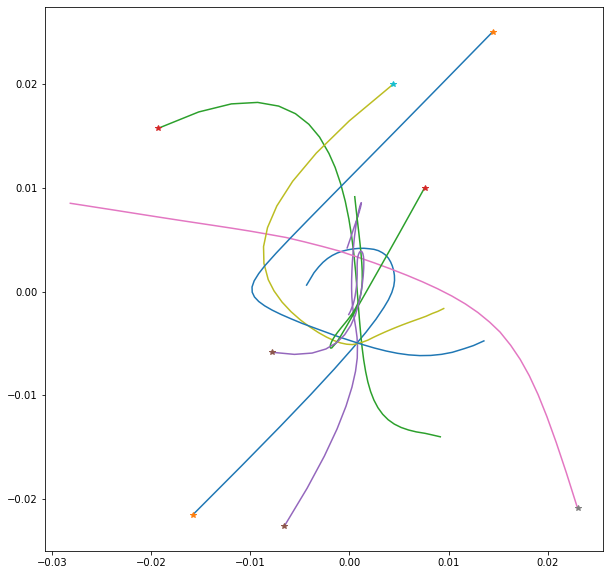

In [209]:
# jPCA analysis part 3

# project activities into the plane of strongest rotations
jPCA1_traces = np.zeros((J, T), dtype=np.float_)
jPCA2_traces = np.zeros((J, T), dtype=np.float_)

for target in range(J):
    jPCA1_traces[target, :] = np.matmul(u1s[trg,:], c_tensor[:,target,:])
    jPCA2_traces[target, :] = np.matmul(u2s[trg,:], c_tensor[:,target,:])

jpca_fig =  plt.figure(figsize=(10,10))
for target in range(J):
    plt.plot(jPCA1_traces[target,:], jPCA2_traces[target,:])
    plt.plot(jPCA1_traces[target,0], jPCA2_traces[target,0], '*')

plt.show()

In [210]:
# jPCA analysis part 2

import scipy as sp
# Obtain the plane of strongest rotation

X = np.zeros((J*T,I))
for j in range(J):
    X[j*T:(j+1)*T, :] = c_tensor[:,j,:].transpose()

# create the block-matrix version of X
Xtilde = sp.linalg.block_diag(*([X]*I))

# Create the H matrix
n = X.shape[1]
ct = X.shape[0]
L = np.zeros((n,n), dtype=int)
c = 0
for row in range(n):
    for col in range(row+1, n):
        L[row, col] = c
        L[col, row] = c
        c += 1
        
H = np.zeros((n*n, int(0.5*n*(n-1))))
for col in range(n):
    for row in range(n):
        if col > row:
            H[n*col+row, L[col,row]] = 1.
        elif row > col:
            H[n*col+row, L[col,row]] = -1.
            
# Approximate the derivatives of X
Xp = np.zeros_like(X)
t_bit = times[1] - times[0]
Xp[1:,:] = (X[1:,:] - X[:-1,:]) / t_bit

xp = Xp.flatten('F')

kstar = np.matmul(np.linalg.pinv(np.matmul(Xtilde, H)), xp)

# reconstruct the matrix that generated the data
Mstar = np.matmul(H, kstar).reshape(n,n)

# Next,extract the eigenvalues of M.
eig_vals, eig_vecs = np.linalg.eig(Mstar)
# print(Mstar)
print("Eigenvalues: ")
print(eig_vals)
print("Eigenvectors: ")
print(eig_vecs)

eig_vals_norms = np.sqrt((eig_vals * eig_vals.conj()).real)
ev_sum = eig_vals_norms.sum()/2.
var_percentages = eig_vals_norms[np.array([0,2,4])] / ev_sum
print("Variance percentages by each conjugate eigenvalue pair")
print(var_percentages)

# We obtain the plane of strongest rotations
srt_idxs = np.argsort(-eig_vals_norms) # indexes for sorting in decreasing order
srt_eig_vecs = eig_vecs[:, srt_idxs]
u1 = (srt_eig_vecs[:,0] + srt_eig_vecs[:,1]).real
u2 = (1j * (srt_eig_vecs[:,0] - srt_eig_vecs[:,1])).real
u1 = u1 / np.linalg.norm(u1)
u2 = u2 / np.linalg.norm(u2)


Eigenvalues: 
[ 6.93889390e-17+14.24700232j  6.93889390e-17-14.24700232j
 -1.15912692e-69+12.54126259j -1.15912692e-69-12.54126259j
  2.77555756e-17 +1.45458141j  2.77555756e-17 -1.45458141j]
Eigenvectors: 
[[-0.31844002-0.14470923j -0.31844002+0.14470923j  0.60508753+0.j
   0.60508753-0.j         -0.00717348+0.10711121j -0.00717348-0.10711121j]
 [-0.61825264+0.j         -0.61825264-0.j         -0.3300708 +0.07296549j
  -0.3300708 -0.07296549j  0.05093568+0.02997567j  0.05093568-0.02997567j]
 [ 0.00315736+0.24896205j  0.00315736-0.24896205j -0.02069914-0.40842137j
  -0.02069914+0.40842137j  0.20874504+0.47665183j  0.20874504-0.47665183j]
 [ 0.06585474+0.0094977j   0.06585474-0.0094977j   0.04432591+0.32295274j
   0.04432591-0.32295274j  0.62394686+0.j          0.62394686-0.j        ]
 [-0.02912753+0.57671301j -0.02912753-0.57671301j  0.10702614+0.33769836j
   0.10702614-0.33769836j -0.18809919+0.07534988j -0.18809919-0.07534988j]
 [ 0.10566174-0.2904979j   0.10566174+0.2904979j  -0.105

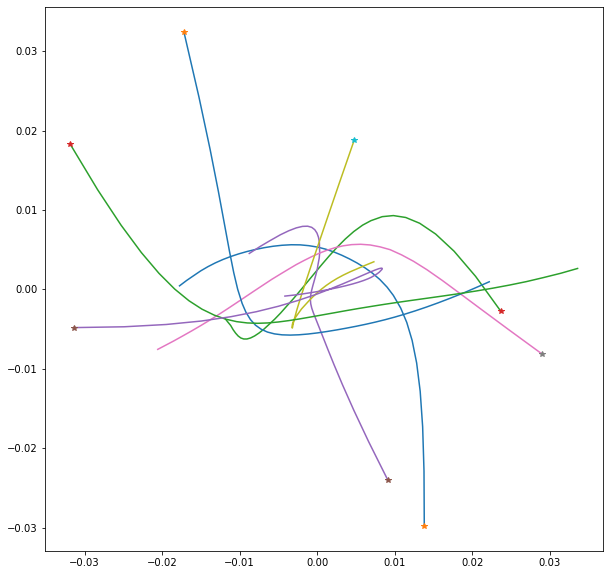

In [211]:
# jPCA analysis part 3

# project activities into the plane of strongest rotations
jPCA1_traces = np.zeros((J, T), dtype=np.float_)
jPCA2_traces = np.zeros((J, T), dtype=np.float_)
u1 = u1.reshape(1,6)
u2 = u2.reshape(1,6)

for target in range(J):
    jPCA1_traces[target, :] = np.matmul(u1, c_tensor[:,target,:])
    jPCA2_traces[target, :] = np.matmul(u2, c_tensor[:,target,:])

jpca_fig =  plt.figure(figsize=(10,10))
for target in range(J):
    plt.plot(jPCA1_traces[target,:], jPCA2_traces[target,:])
    plt.plot(jPCA1_traces[target,0], jPCA2_traces[target,0], '*')

plt.show()

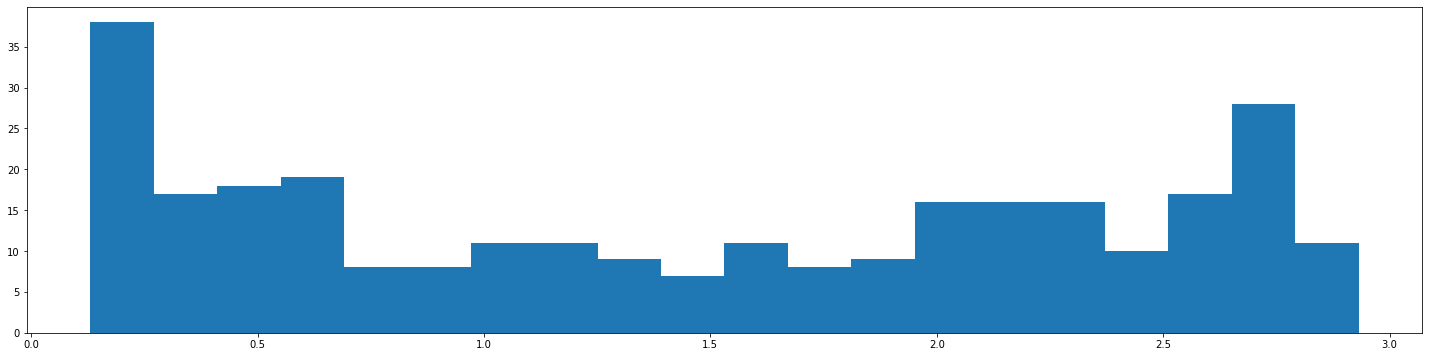

In [212]:
# jPCA part 4
# Other measures of rotation

# 1) average angle between X and Xp
X_norms = np.linalg.norm(X, axis=1)
Xp_norms = np.linalg.norm(Xp, axis=1)
X_cos = (X * Xp).sum(axis=1) / (X_norms * Xp_norms + 1e-10)
X_angs = np.arccos(X_cos)

n_bins = 20
hist_fig = plt.figure(figsize=fs)
plt.hist(X_angs, bins=n_bins)

plt.show()

In [201]:
X_angs[100:110]

array([0.65186659, 0.56523682, 0.474886  , 0.41585777, 0.35142231,
       0.30586481, 0.27667274, 0.26161774, 0.26801005, 0.28671148])

In [ ]:
w_sum = 0.
for syn in net.syns[C[0]]:
    if syn.type is synapse_types.rga_21:
        w_sum += syn.w
        
print(w_sum)

n_syns = 0
for syn_list in net.syns:
    for syn in syn_list:
        n_syns += 1
print(n_syns)
print(len(net.units))

In [ ]:
import cProfile
import pstats
sim_time = 5.
start_time = time.time()
#cProfile.run('times, data, _  = net.run(sim_time)', 't2p3stats')
cProfile.run('times, data, plant_data  = net.flat_run(sim_time)', 'v3ft3p2_stats')
#times, data, _  = net.run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

In [ ]:
p = pstats.Stats('v3ft3p2_stats')
p.sort_stats('cumtime').print_stats(50)

In [ ]:
# restore A__M connections
for mid in M:
    for syn in net.syns[mid]:
        if syn.type is synapse_types.inp_sel:
            syn.w_sum = 2.5
            syn.w_max = 1.2
            syn.l_rate = 10.
            syn.alpha = syn.l_rate * net.min_delay

In [ ]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=5*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [ ]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

---